In [1]:
import numpy as np 
import pandas as pd

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e20/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e20/test.csv')

#For reproducible results
random_state = 42

In [3]:
# EDA - look at the shape of the dataset
train.shape

(79023, 76)

In [4]:
train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


In [5]:
# Understand data types
pd.set_option('display.max_rows', None)
train.dtypes

ID_LAT_LON_YEAR_WEEK                                         object
latitude                                                    float64
longitude                                                   float64
year                                                          int64
week_no                                                       int64
SulphurDioxide_SO2_column_number_density                    float64
SulphurDioxide_SO2_column_number_density_amf                float64
SulphurDioxide_SO2_slant_column_number_density              float64
SulphurDioxide_cloud_fraction                               float64
SulphurDioxide_sensor_azimuth_angle                         float64
SulphurDioxide_sensor_zenith_angle                          float64
SulphurDioxide_solar_azimuth_angle                          float64
SulphurDioxide_solar_zenith_angle                           float64
SulphurDioxide_SO2_column_number_density_15km               float64
CarbonMonoxide_CO_column_number_density         

In [6]:
# Understand the target variable
train['emission'].describe()

count    79023.000000
mean        81.940552
std        144.299648
min          0.000000
25%          9.797995
50%         45.593445
75%        109.549595
max       3167.768000
Name: emission, dtype: float64

In [7]:
# check percentage of missing values
100*train.isna().sum()/len(train)

ID_LAT_LON_YEAR_WEEK                                         0.000000
latitude                                                     0.000000
longitude                                                    0.000000
year                                                         0.000000
week_no                                                      0.000000
SulphurDioxide_SO2_column_number_density                    18.487023
SulphurDioxide_SO2_column_number_density_amf                18.487023
SulphurDioxide_SO2_slant_column_number_density              18.487023
SulphurDioxide_cloud_fraction                               18.487023
SulphurDioxide_sensor_azimuth_angle                         18.487023
SulphurDioxide_sensor_zenith_angle                          18.487023
SulphurDioxide_solar_azimuth_angle                          18.487023
SulphurDioxide_solar_zenith_angle                           18.487023
SulphurDioxide_SO2_column_number_density_15km               18.487023
CarbonMonoxide_CO_co

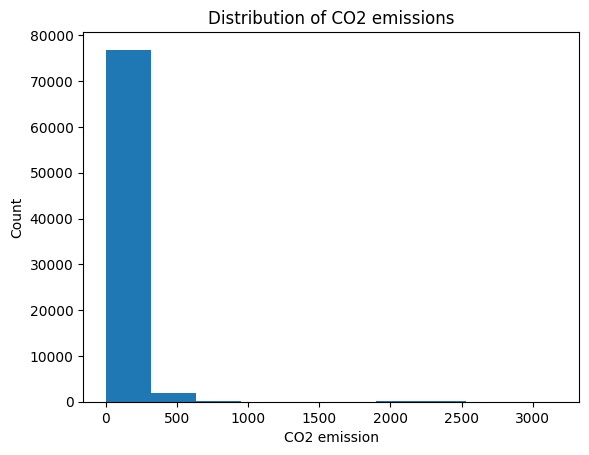

In [8]:
# Visualize the target variable
import matplotlib
from matplotlib import pylab as plt
train['emission'].plot.hist()
plt.xlabel('CO2 emission')
plt.ylabel('Count')
plt.title('Distribution of CO2 emissions')
plt.show()

From the above plot, we can see that the CO2 emission is skewed and follows a long tail distribution

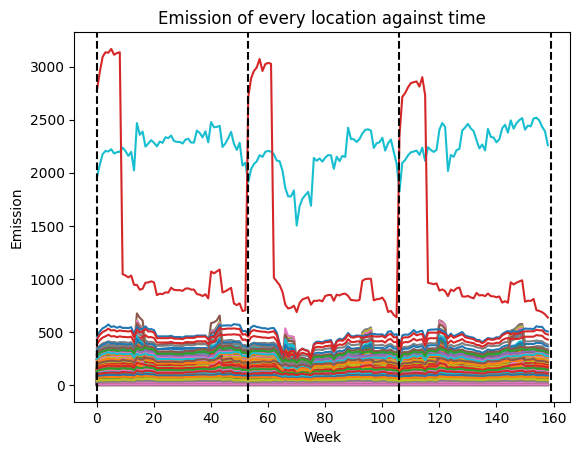

In [9]:
#Seasonality Analysis
for name, group in train.groupby(['latitude', 'longitude']):
    time_series = group['emission']
    plt.plot(range(len(time_series)), time_series)

#year separator
for week in [0, 53, 106, 159]:
    plt.axvline(week, color='k', linestyle='--')

plt.title('Emission of every location against time')
plt.xlabel('Week')
plt.ylabel('Emission')
plt.show()

From the diagram above, we can see that there are two major outliers who have high CO2 emission. For the location labeled in red, we can also see that the emissions are significantly higher during start of the year.

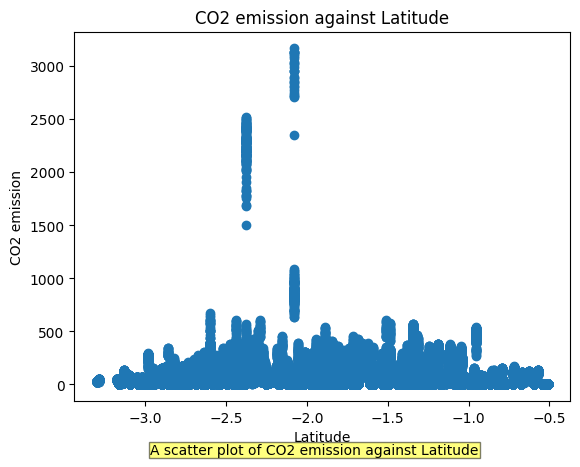

In [10]:
# CO2 against latitude
plt.scatter(train['latitude'], train['emission'])
plt.title('CO2 emission against Latitude')
plt.xlabel('Latitude')
plt.ylabel('CO2 emission')
#Add caption
plt.figtext(0.5, 0.0001, "A scatter plot of CO2 emission against Latitude", ha='center', bbox={"facecolor":"yellow", "alpha":0.5, "pad":1})
plt.show()

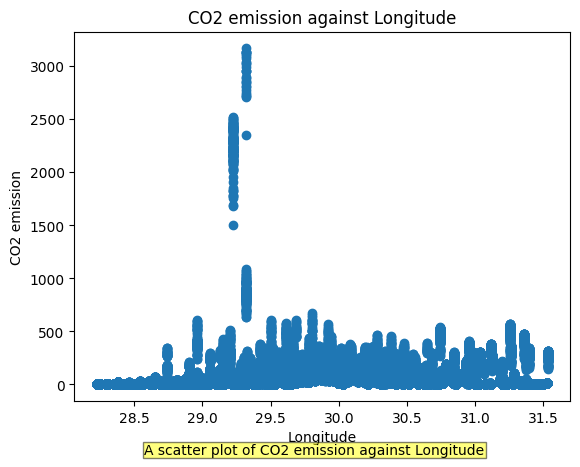

In [11]:
# CO2 against longitude
plt.scatter(train['longitude'], train['emission'])
plt.title('CO2 emission against Longitude')
plt.xlabel('Longitude')
plt.ylabel('CO2 emission')
#Add caption
plt.figtext(0.5, 0.0001, "A scatter plot of CO2 emission against Longitude", ha='center', bbox={"facecolor":"yellow", "alpha":0.5, "pad":1})
plt.show()

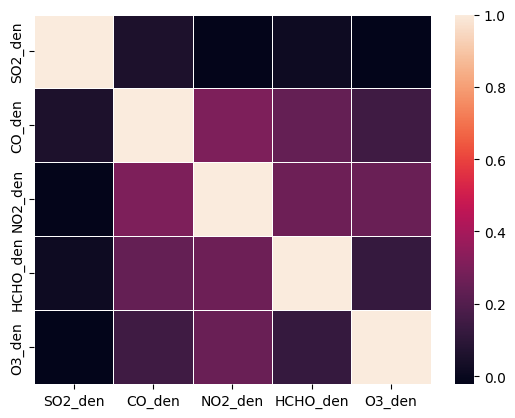

In [12]:
import seaborn as sns

#rename columns for better heatmap display
train.rename(columns = {'SulphurDioxide_SO2_column_number_density':'SO2_den', 'CarbonMonoxide_CO_column_number_density': 'CO_den', 'NitrogenDioxide_NO2_column_number_density':'NO2_den', 'Formaldehyde_tropospheric_HCHO_column_number_density':'HCHO_den', 'Ozone_O3_column_number_density': 'O3_den'}, inplace = True)
density = train[['SO2_den', 'CO_den', 'NO2_den', 'HCHO_den', 'O3_den']].corr()
ax = sns.heatmap(density, linewidth=0.5)

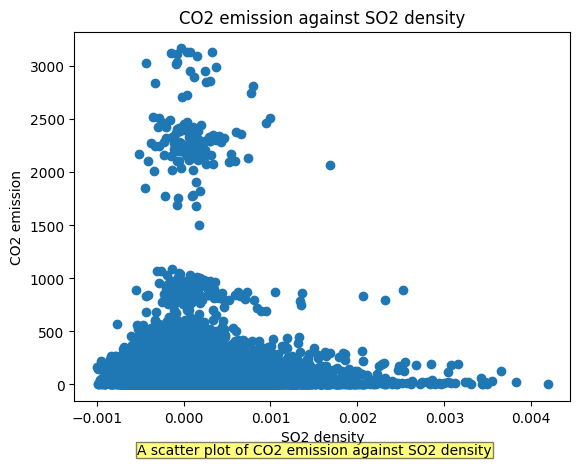

In [13]:
# CO2 against SO2
plt.scatter(train['SO2_den'], train['emission'])
plt.title('CO2 emission against SO2 density')
plt.xlabel('SO2 density')
plt.ylabel('CO2 emission')
#Add caption
plt.figtext(0.5, 0.0001, "A scatter plot of CO2 emission against SO2 density", ha='center', bbox={"facecolor":"yellow", "alpha":0.5, "pad":1})
plt.show()

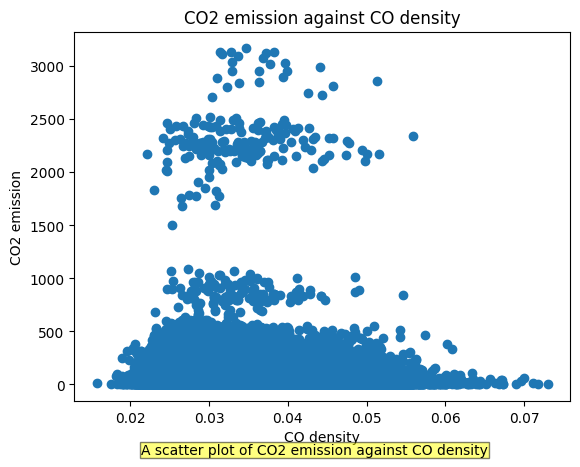

In [14]:
# CO2 against CO
plt.scatter(train['CO_den'], train['emission'])
plt.title('CO2 emission against CO density')
plt.xlabel('CO density')
plt.ylabel('CO2 emission')
#Add caption
plt.figtext(0.5, 0.0001, "A scatter plot of CO2 emission against CO density", ha='center', bbox={"facecolor":"yellow", "alpha":0.5, "pad":1})
plt.show()

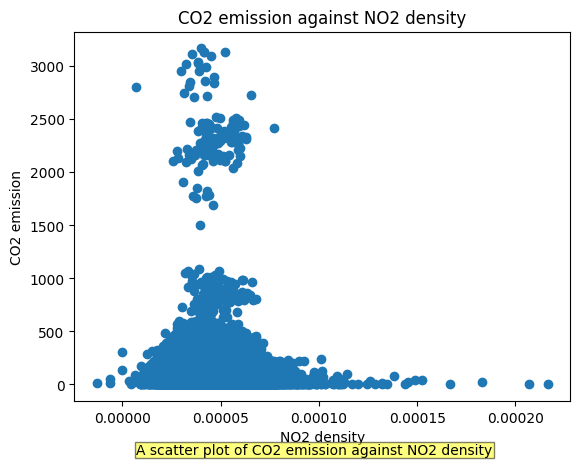

In [15]:
# CO2 against NO2
plt.scatter(train['NO2_den'], train['emission'])
plt.title('CO2 emission against NO2 density')
plt.xlabel('NO2 density')
plt.ylabel('CO2 emission')
#Add caption
plt.figtext(0.5, 0.0001, "A scatter plot of CO2 emission against NO2 density", ha='center', bbox={"facecolor":"yellow", "alpha":0.5, "pad":1})
plt.show()

From the correlation analysis of different gases against CO2, we can see that the data is too noisy, thus the modeling would be focused on predicting the CO2 emissions through time and location

In [16]:
#TODO - Explain why all other features are noises except location, year, date

In [17]:
#Cross validation with LeaveOneGroupOut() splitting for time series
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error 

def cross_val(model, name = ''):
    logo = LeaveOneGroupOut()
    train_scores = []
    val_scores = []

    for fold, (idx_train, idx_val) in enumerate(logo.split(train, groups=train.year)):
        X_train = train.iloc[idx_train][['longitude', 'latitude', 'week_no']]
        y_train = train.iloc[idx_train]['emission']
        X_val = train.iloc[idx_val][['longitude', 'latitude', 'week_no']]
        y_val = train.iloc[idx_val]['emission']

        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        train_score = mean_squared_error(y_train, y_train_pred, squared = False)
        val_score = mean_squared_error(y_val, y_val_pred, squared = False)

        train_scores.append(train_score)
        val_scores.append(val_score)
    
    print('mean of ' + name + ' train scores is ' + str(np.mean(train_scores)))
    print('standard deviation of ' + name + ' train scores is ' + str(np.std(train_scores)))
    print('mean of ' + name + ' validation scores is ' + str(np.mean(val_scores)))
    print('standard deviation of ' + name + ' validation scores is ' + str(np.std(val_scores)))
    return val_scores

In [18]:
#Model 1 - RandomForest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = random_state, n_jobs = -1)
rf_score = cross_val(rf, 'Random Forest')

mean of Random Forest train scores is 13.067887743126393
standard deviation of Random Forest train scores is 2.14502554492515
mean of Random Forest validation scores is 22.089458976288423
standard deviation of Random Forest validation scores is 3.5038367172383817


In [19]:
#Model 2 - XGBoost
from xgboost import XGBRegressor
xgb = XGBRegressor(random_state = random_state, n_jobs = -1)
xgb_score = cross_val(xgb, 'XGBoost')

mean of XGBoost train scores is 17.538796302893132
standard deviation of XGBoost train scores is 1.6944318175285622
mean of XGBoost validation scores is 24.117242911527324
standard deviation of XGBoost validation scores is 2.3379494669734453


In [20]:
#Model 3 - Linear Regression 
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg_score = cross_val(reg, 'LinearRegression')

mean of LinearRegression train scores is 143.4850905863851
standard deviation of LinearRegression train scores is 2.451890280353434
mean of LinearRegression validation scores is 143.55159947672792
standard deviation of LinearRegression validation scores is 4.954898628236979


In [21]:
#Model 4 - KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor()
neigh_score = cross_val(neigh, 'KNeighborsRegressor')

mean of KNeighborsRegressor train scores is 101.35123567103244
standard deviation of KNeighborsRegressor train scores is 1.541598142654383
mean of KNeighborsRegressor validation scores is 102.35889694386198
standard deviation of KNeighborsRegressor validation scores is 3.638793638196241


From the above cross validation scores, we can see that ensemble learning techniques would be more appropriate and accurate for this dataset